<a href="https://colab.research.google.com/github/bintualkassoum/bintualkassoum/blob/main/CompasFairML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Objective: The goal of this project is to identify which factors have the strongest impact on recidivism rates. Aligning with O'Neil (Weapons of Math Destruction), I argue that predictive models have the potential to generate negative feedback loops, which can then impact the individuals represented in these models. These feedback loops are perpetuated by their opacity, scale, and societal damage. 

I will then analyze these results against COMPAS in an attempt to re-create a better, less harmful, and more effective model. 

Afterwards, I will run this model against other data sets to ensure its effectiveness, as this data set is limited to Broward County, Florida. 

Feature Engineering Info: 
Drop age_cat, first, last, 
c_jail_in and c_jail_out (several values small time frame and similar), 
c_days_from_compas (too many similar values across rows), 

In [2]:
#Import Packages
import pandas as pd 
import os 
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
!pip install --upgrade category_encoders
import category_encoders as ce
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Import Libraries 
from pandas import read_csv
from pandas.plotting import scatter_matrix
from pandas.core.common import random_state
from sklearn import neighbors, metrics, utils
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LinearRegression, LogisticRegression, Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, Normalizer, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn import preprocessing
from sklearn.inspection import permutation_importance
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from matplotlib import style
from sklearn import tree
from matplotlib import pyplot
import time 
from IPython.display import Image  
from six import StringIO
from sklearn.tree import export_graphviz
import pydotplus, graphviz
!pip install dtreeviz
from dtreeviz.trees import dtreeviz 
!pip install shap 
import shap
!pip install dmba 
import dmba

In [4]:
#Install Deployment Packages 
!pip install --upgrade pip

In [5]:
#Import Offender Data Set
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
#Import Offender Data Set
off_data = pd.read_csv('/content/drive/MyDrive/Grad School/Misc/Fair Machine Learning (COMPAS)/cox-violent-parsed.csv')
print(off_data.head(5))

print(off_data.shape)

off_data.head()

    id              name    first       last compas_screening_date   sex  \
0  1.0  miguel hernandez   miguel  hernandez            14/08/2013  Male   
1  2.0  miguel hernandez   miguel  hernandez            14/08/2013  Male   
2  3.0      michael ryan  michael       ryan            31/12/2014  Male   
3  4.0       kevon dixon    kevon      dixon            27/01/2013  Male   
4  5.0          ed philo       ed      philo            14/04/2013  Male   

          dob  age          age_cat              race  ...  \
0  18/04/1947   69  Greater than 45             Other  ...   
1  18/04/1947   69  Greater than 45             Other  ...   
2  06/02/1985   31          25 - 45         Caucasian  ...   
3  22/01/1982   34          25 - 45  African-American  ...   
4  14/05/1991   24     Less than 25  African-American  ...   

   v_type_of_assessment  v_decile_score  v_score_text  v_screening_date  \
0      Risk of Violence               1           Low        14/08/2013   
1      Risk of Viole

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event
0,1.0,miguel hernandez,miguel,hernandez,14/08/2013,Male,18/04/1947,69,Greater than 45,Other,...,Risk of Violence,1,Low,14/08/2013,07/07/2014,14/07/2014,0,0,327,0
1,2.0,miguel hernandez,miguel,hernandez,14/08/2013,Male,18/04/1947,69,Greater than 45,Other,...,Risk of Violence,1,Low,14/08/2013,07/07/2014,14/07/2014,0,334,961,0
2,3.0,michael ryan,michael,ryan,31/12/2014,Male,06/02/1985,31,25 - 45,Caucasian,...,Risk of Violence,2,Low,31/12/2014,30/12/2014,03/01/2015,0,3,457,0
3,4.0,kevon dixon,kevon,dixon,27/01/2013,Male,22/01/1982,34,25 - 45,African-American,...,Risk of Violence,1,Low,27/01/2013,26/01/2013,05/02/2013,0,9,159,1
4,5.0,ed philo,ed,philo,14/04/2013,Male,14/05/1991,24,Less than 25,African-American,...,Risk of Violence,3,Low,14/04/2013,16/06/2013,16/06/2013,4,0,63,0


In [ ]:
#Check Null Values (Offender Data)
total_nulls = off_data.isnull().sum()
total_observations = off_data.shape[0]

null_percentages = total_nulls[total_nulls > 0] / total_observations * 100
total_nulls = total_nulls[total_nulls > 0]

pd.concat([total_nulls, null_percentages], axis = 1, keys = ["Total Nulls", "Percentage"]).sort_values(by = "Total Nulls", ascending = False)


,Total Nulls,Percentage
violent_recid,18316,100.000000
vr_charge_desc,16977,92.689452
vr_offense_date,16977,92.689452
vr_charge_degree,16977,92.689452
vr_case_number,16977,92.689452
c_arrest_date,15231,83.156803
r_jail_out,11957,65.281721
r_jail_in,11957,65.281721
r_days_from_arrest,11957,65.281721
r_charge_desc,10039,54.810002


In [ ]:
#Drop Null Values 
off_data.dropna(axis='columns', thresh= 17000)

,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,...,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event
0,miguel hernandez,miguel,hernandez,14/08/2013,Male,18/04/1947,69,Greater than 45,Other,0,...,Risk of Violence,1,Low,14/08/2013,07/07/2014,14/07/2014,0,0,327,0
1,miguel hernandez,miguel,hernandez,14/08/2013,Male,18/04/1947,69,Greater than 45,Other,0,...,Risk of Violence,1,Low,14/08/2013,07/07/2014,14/07/2014,0,334,961,0
2,michael ryan,michael,ryan,31/12/2014,Male,06/02/1985,31,25 - 45,Caucasian,0,...,Risk of Violence,2,Low,31/12/2014,30/12/2014,03/01/2015,0,3,457,0
3,kevon dixon,kevon,dixon,27/01/2013,Male,22/01/1982,34,25 - 45,African-American,0,...,Risk of Violence,1,Low,27/01/2013,26/01/2013,05/02/2013,0,9,159,1
4,ed philo,ed,philo,14/04/2013,Male,14/05/1991,24,Less than 25,African-American,0,...,Risk of Violence,3,Low,14/04/2013,16/06/2013,16/06/2013,4,0,63,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18311,alexsandra beauchamps,alexsandra,beauchamps,29/12/2014,Female,21/12/1984,31,25 - 45,African-American,0,...,Risk of Violence,4,Low,29/12/2014,28/12/2014,07/01/2015,5,9,459,0
18312,winston gregory,winston,gregory,14/01/2014,Male,01/10/1958,57,Greater than 45,Other,0,...,Risk of Violence,1,Low,14/01/2014,13/01/2014,14/01/2014,0,0,808,0
18313,farrah jean,farrah,jean,09/03/2014,Female,17/11/1982,33,25 - 45,African-American,0,...,Risk of Violence,2,Low,09/03/2014,08/03/2014,09/03/2014,3,0,754,0
18314,florencia sanmartin,florencia,sanmartin,30/06/2014,Female,18/12/1992,23,Less than 25,Hispanic,0,...,Risk of Violence,4,Low,30/06/2014,15/03/2015,15/03/2015,2,0,258,0


In [7]:
#Drop Duplicate Rows 
off_data.drop_duplicates(subset=['name', 'score_text'], keep='first')
off_data[off_data.duplicated(keep='first')]

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event


In [8]:
#Combine all Juvenile Counts 
off_data['juv_misd_count']. value_counts()

off_data['juv_fel_count']. value_counts()

off_data['juv_other_count']. value_counts()

juv_count = off_data['juv_misd_count'] + off_data['juv_fel_count'] + off_data['juv_other_count']
off_data['juv_count'] = juv_count

In [9]:
#Combine Custody Dates 
off_data['in_custody'] = pd.to_datetime(off_data['in_custody'])
off_data['out_custody'] = pd.to_datetime(off_data['out_custody'])
off_data['custody_duration'] = (off_data['out_custody'] - off_data['in_custody']).dt.days

#Several dates inputted incorrectly, so I will drop all three categories 

In [10]:
#Combine Violent and Non-Violent Recidivisim (Target Variable)
total_recid = off_data['is_recid'] + off_data['is_violent_recid']
off_data['total_recid'] = total_recid

In [ ]:
#Combine Decile and Violent Decile Scores (Target Variable)
recid_score = (off_data['decile_score'] + off_data['v_decile_score']) / 2
off_data['recid_score'] = recid_score.astype(int)

off_data.head()

In [12]:
#Data Cleaning - Feature Engineer Recid Scores
r = [0,4,7,10]
g = ['Low','Medium','High']
off_data['recid_score'] = pd.cut(off_data['recid_score'], bins = r, labels = g)

off_data

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,in_custody,out_custody,priors_count.1,start,end,event,juv_count,custody_duration,total_recid,recid_score
0,1.0,miguel hernandez,miguel,hernandez,14/08/2013,Male,18/04/1947,69,Greater than 45,Other,...,2014-07-07,2014-07-14,0,0,327,0,0,7.0,0,Low
1,2.0,miguel hernandez,miguel,hernandez,14/08/2013,Male,18/04/1947,69,Greater than 45,Other,...,2014-07-07,2014-07-14,0,334,961,0,0,7.0,0,Low
2,3.0,michael ryan,michael,ryan,31/12/2014,Male,06/02/1985,31,25 - 45,Caucasian,...,2014-12-30,2015-03-01,0,3,457,0,0,61.0,-1,Low
3,4.0,kevon dixon,kevon,dixon,27/01/2013,Male,22/01/1982,34,25 - 45,African-American,...,2013-01-26,2013-05-02,0,9,159,1,0,96.0,2,Low
4,5.0,ed philo,ed,philo,14/04/2013,Male,14/05/1991,24,Less than 25,African-American,...,2013-06-16,2013-06-16,4,0,63,0,1,0.0,1,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18311,NaN,alexsandra beauchamps,alexsandra,beauchamps,29/12/2014,Female,21/12/1984,31,25 - 45,African-American,...,2014-12-28,2015-07-01,5,9,459,0,0,185.0,0,Medium
18312,NaN,winston gregory,winston,gregory,14/01/2014,Male,01/10/1958,57,Greater than 45,Other,...,2014-01-13,2014-01-14,0,0,808,0,0,1.0,0,Low
18313,NaN,farrah jean,farrah,jean,09/03/2014,Female,17/11/1982,33,25 - 45,African-American,...,2014-08-03,2014-09-03,3,0,754,0,0,31.0,0,Low
18314,NaN,florencia sanmartin,florencia,sanmartin,30/06/2014,Female,18/12/1992,23,Less than 25,Hispanic,...,2015-03-15,2015-03-15,2,0,258,0,0,0.0,1,Low


In [13]:
#Final Data Cleaning 

column_names = ['sex', 'age', 'race', 'juv_count', 'priors_count',
                'c_charge_degree', 'recid_score']
data = pd.DataFrame(off_data, columns=column_names)

data.loc[data['recid_score'] == -1]
data = data.drop([900, 1269, 1270, 5018, 13669, 17695])

data = data.dropna()

data

,sex,age,race,juv_count,priors_count,c_charge_degree,recid_score
0,Male,69,Other,0,0,(F3),Low
1,Male,69,Other,0,0,(F3),Low
3,Male,34,African-American,0,0,(F3),Low
4,Male,24,African-American,1,4,(F3),Low
5,Male,24,African-American,1,4,(F3),Low
...,...,...,...,...,...,...,...
18311,Female,31,African-American,0,5,(M1),Medium
18312,Male,57,Other,0,0,(F2),Low
18313,Female,33,African-American,0,3,(M1),Low
18314,Female,23,Hispanic,0,2,(F3),Low


In [14]:
#Exploratory Data Analysis 
data_num = data[['age', 'juv_count', 'priors_count', 'recid_score']]
data_cat = data[['sex', 'race', 'c_charge_degree']] 

#Data Distribution 
fig, ax = plt.subplots(figsize=(11, 11))
data.hist(bins=100, ax=ax)

#Skew of Data 
skew = data.skew()
pd.DataFrame(data = skew, columns=['Skew'])

To output multiple subplots, the figure containing the passed axes is being cleared
Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


,Skew
age,0.968166
juv_count,6.429407
priors_count,2.157277


In [15]:
#Pivot Tables for Categorical Variables 
print(pd.pivot_table(data, index = 'recid_score', columns = 'sex', values = 'age', aggfunc = 'count'))
print(pd.pivot_table(data, index = 'recid_score', columns = 'race', values = 'age', aggfunc = 'count'))
print(pd.pivot_table(data, index = 'recid_score', columns = 'c_charge_degree', values = 'age', aggfunc = 'count'))
print(pd.pivot_table(data, index = 'recid_score', values = ['age', 'juv_count', 'priors_count']))

sex          Female  Male
recid_score              
Low            2043  7516
Medium          879  4482
High            272  2249
race         African-American  Asian  Caucasian  Hispanic  Native American  \
recid_score                                                                  
Low                      3933     48       3955       963               24   
Medium                   3512     12       1394       271               16   
High                     1953      4        411       113                9   

race         Other  
recid_score         
Low            636  
Medium         156  
High            31  
c_charge_degree  (CO3)  (CT)  (F1)  (F2)  (F3)  (F5)  (F6)  (F7)  (M1)  (M2)  \
recid_score                                                                    
Low                  6     1   171   708  5207     7     8   111  2527   738   
Medium               0     0    73   497  3456     6     5    44   853   375   
High                 0     0    53   298  1629     0  

In [16]:
#Histograph for Categorical Features 
for i in data_cat.columns:
    sns.barplot(data_cat[i].value_counts().index,data_cat[i].value_counts()).set_title(i)
    plt.show()

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


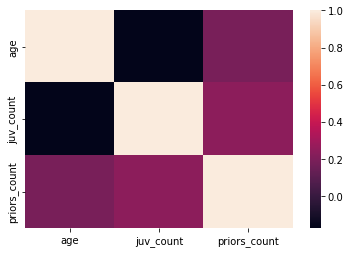

In [ ]:
#Data Visulaization - Heatmap Plot
corr = data.corr()

sns.heatmap(corr)

In [19]:
#Split Original Data Set 
X = pd.get_dummies(data=data, columns=['sex', 'race', 'c_charge_degree'])
X = X.drop(columns=['recid_score'], axis=1)

y = pd.DataFrame(data=data['recid_score'], columns=['recid_score'])

le = preprocessing.LabelEncoder()

y = le.fit_transform(y)
y.ravel()
y

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


array([1, 1, 1, ..., 1, 1, 1])

In [20]:
data.isnull().any()

sex                False
age                False
race               False
juv_count          False
priors_count       False
c_charge_degree    False
recid_score        False
dtype: bool

In [21]:
#Split Original Data Set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=8)

print("X_train Shape: {}".format(X_train.shape))
print("X_test Shape: {}".format(X_test.shape))
print("y_train Shape: {}".format(y_train.shape))
print("y_test Shape: {}".format(y_test.shape))

X_train Shape: (13952, 25)
X_test Shape: (3489, 25)
y_train Shape: (13952,)
y_test Shape: (3489,)


In [22]:
#Standardize Data 
scaler = StandardScaler()
scaler.fit(X_train) 
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [23]:
#Train Model - Logistic Regression with SGD Training 
clf = SGDClassifier(loss='log', penalty='l2')
clf.fit(X_train, y_train)

SGDClassifier(loss='log')

In [24]:
#Feature Importance - Decision Tree 
# define the model
model = DecisionTreeClassifier()
# fit the model
model.fit(X_train, y_train)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.title("COMPAS Feature Importance")
pyplot.show()

Feature: 0, Score: 0.35736
Feature: 1, Score: 0.06069
Feature: 2, Score: 0.31048
Feature: 3, Score: 0.02189
Feature: 4, Score: 0.02231
Feature: 5, Score: 0.03049
Feature: 6, Score: 0.00070
Feature: 7, Score: 0.02590
Feature: 8, Score: 0.01643
Feature: 9, Score: 0.00225
Feature: 10, Score: 0.00818
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00901
Feature: 14, Score: 0.02896
Feature: 15, Score: 0.03854
Feature: 16, Score: 0.00010
Feature: 17, Score: 0.00021
Feature: 18, Score: 0.00645
Feature: 19, Score: 0.03178
Feature: 20, Score: 0.01826
Feature: 21, Score: 0.00882
Feature: 22, Score: 0.00120
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000


In [27]:
#Building ML Models 

#Random Forest:
random_forest = RandomForestClassifier(n_estimators=2000)
random_forest.fit(X_train, y_train)

y_pred = random_forest.predict(X_test)

random_forest.score(X_train, y_train)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)

#Logistic Regression:
logreg = LogisticRegression(max_iter=3000)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, y_train) * 100, 2)

#K Nearest Neighbor (KNN):
knn = neighbors.KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

acc_knn = round(knn.score(X_train, y_train) * 100, 2)

#Gaussian Naive Bayes:
gaussian = GaussianNB() 
gaussian.fit(X_train, y_train)  

y_pred = gaussian.predict(X_test) 

acc_gaussian = round(gaussian.score(X_train, y_train) * 100, 2)

#Results
results = pd.DataFrame({
    'Model': ['Random Forest', 'Logistic Regression', 'KNN', 'Naive Bayes'],
    'Score': [acc_random_forest, acc_log, acc_knn, acc_gaussian]})
result_data = results.sort_values(by='Score', ascending=False)
result_data = result_data.set_index('Score')
result_data.head()

,Model
Score,
86.66,Random Forest
81.00,KNN
65.54,Logistic Regression
15.52,Naive Bayes


In [ ]:
#Confusion Matrix 
print(confusion_matrix(y_test, y_pred))

In [29]:
#Cross Validation 

print(cross_val_score(random_forest, X_train, y_train, cv=3).mean())

print(cross_val_score(logreg, X_train, y_train, cv=3).mean())

print(cross_val_score(knn, X_train, y_train, cv=3).mean())

print(cross_val_score(gaussian, X_train, y_train, cv=3).mean())

KeyboardInterrupt: ignored

In [ ]:
#Random Forest: Hyperparameter Tuning 
#Grid Search Parameters
random_forest = RandomForestClassifier(random_state=42)

n_estimators = [10, 100, 1000, 2000]
max_depth = [None, 5, 10, 20]
criterion = ['gini', 'entropy']
max_features = ['auto', 'sqrt', 'log2']
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion=criterion,
                  max_features=max_features)

grid = GridSearchCV(estimator=random_forest, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

#Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


In [30]:
random_forest = RandomForestClassifier(max_depth=3, n_estimators=200)
random_forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=200)

In [31]:
explainer = shap.TreeExplainer(random_forest)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

In [ ]:
plt.figure(figsize=(20,20))

tree.plot_tree(random_forest.estimators_[0], feature_names=X.columns, filled=True)

In [ ]:
viz = dtreeviz(random_forest.estimators_[0], X_train, y_train, feature_names=X.columns,
               target_name="Recidivism Rate", show_node_labels = True)
viz

In [32]:
#Random Forest Confusion Matrix
random_forest = RandomForestClassifier(criterion='entropy', max_depth=None, n_estimators=2000)
random_forest.fit(X_train, y_train)

y_pred = random_forest.predict(X_test)

random_forest.score(X_train, y_train)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)

confusion_matrix(y_test, y_pred)

array([[ 352,   74,  113],
       [  23, 1692,  163],
       [  92,  309,  671]])

In [ ]:
#Random Forest Heatmap
#Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Reds, linewidths=0.2)

# Add labels to the plot
class_names = ['Low Risk', 'Medium Risk', 'High Risk']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks 
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

Our model is the most accurate at predciting medium risk of recidivism and is relatively as accurate at predicting low risk as it is at predicting high risk. 

However, our model inaccurately classified 22% of low risk offenders as high risk and 27% of high risk offenders as medium risk. 

**In the context of this project, the 33% misclassification of low risk offenders as high risk is significantly problematic.**

In [ ]:
#Classification Report 
print(classification_report(y_test, y_pred))

Precision is lowest for Class 2 (high risk offenders), recall is also low between Class 0 (low risk offenders) and Class 2 (high risk offenders), meaning that the model missed classifying some high and low risk offenders, instead classifying them as medium risk (which we see based on the high recall for Class 1).

In [ ]:
random_forest = RandomForestClassifier(criterion='entropy', max_depth=3, n_estimators=2000)
random_forest.fit(X_train, y_train)

viz = dtreeviz(random_forest.estimators_[0], X_train, y_train, feature_names=X.columns,
               target_name="Recidivism Rate", show_node_labels = True)
viz

In [ ]:
#Random Forest Feature Importances 
fig = plt.figure(figsize=(10, 8))
sorted_idx = random_forest.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], random_forest.feature_importances_[sorted_idx],
         height=0.5)
plt.style.use('seaborn-muted')
plt.xlabel("Random Forest Feature Importance")

In [ ]:
#Model Deployment - Tabpy 
!pip install tabpy
import tabpy_client
from tabpy.tabpy_tools.client import Client
client = tabpy_client.Client('http://localhost:9004/')

In [ ]:
def LoanDefaultClassifier(Loan_Amount, Loan_Tenure, Monthly_Income, Age):
    import pandas as pd
    data=pd.concat([Loan_Amount,Loan_Tenure,Monthly_Income,Age],axis=1)
    return gbm.predict(data)

client.deploy('WillItDefault',
              LoanDefaultClassifier,
              'Returns whether a loan application is likely to default.')

In [48]:
#Model Deployment - Tabpy 
def compas_recidivism_predictor( _arg1, _arg2, _arg3, _arg4,_arg5, _arg6, _arg7,
                                _arg8, _arg9, _arg10, _arg11, _arg12, _arg13, _arg14,
                                _arg15, _arg16, _arg17, _arg18, _arg19, _arg20, _arg21,
                                _arg22, _arg23, _arg24, _arg25):
    import pandas as pd

    #Get the new app's data in a dictionary
    row = {'age': _arg1, 'juv_count': _arg2,
           'priors_count': _arg3, 'sex_Female': _arg4,
           'sex_Male': _arg5, 'race_African-American': _arg6,
           'race_Asian	': _arg7, 'race_Caucasian': _arg8,
           'race_Hispanic': _arg9, 'race_Native American': _arg10,
           'race_Other': _arg11,
           'c_charge_degree_(CO3)': _arg12, 'c_charge_degree_(CT)': _arg13,
           'c_charge_degree_(F1)': _arg14, 'c_charge_degree_(F2)': _arg15,
           'c_charge_degree_(F3)': _arg16, 'c_charge_degree_(F5)': _arg17,
           'c_charge_degree_(F6)': _arg18, 'c_charge_degree_(F7)': _arg19,
           'c_charge_degree_(M1)': _arg20, 'c_charge_degree_(M2)': _arg21,
           'c_charge_degree_(MO3)': _arg22, 'c_charge_degree_(N10)': _arg23,
           'c_charge_degree_(TCX)': _arg24, 'c_charge_degree_(X)': _arg25}
    
    #Convert it into a dataframe
    test_data = pd.DataFrame(data = row,index=[0])
    #Predict the survival and death probabilities
    predprob_recid = random_forest.predict_proba(test_data)
    #Return only the survival probability
    return random_forest.predict(test_data)


In [ ]:
import requests
s = requests.session()
s.keep_alive = False

client.deploy('compas_recidivism_predictor', compas_recidivism_predictor,
              'Predicts Recidivism Probability', override = True)

In [42]:
X.columns

Index(['age', 'juv_count', 'priors_count', 'sex_Female', 'sex_Male',
       'race_African-American', 'race_Asian', 'race_Caucasian',
       'race_Hispanic', 'race_Native American', 'race_Other',
       'c_charge_degree_(CO3)', 'c_charge_degree_(CT)', 'c_charge_degree_(F1)',
       'c_charge_degree_(F2)', 'c_charge_degree_(F3)', 'c_charge_degree_(F5)',
       'c_charge_degree_(F6)', 'c_charge_degree_(F7)', 'c_charge_degree_(M1)',
       'c_charge_degree_(M2)', 'c_charge_degree_(MO3)',
       'c_charge_degree_(NI0)', 'c_charge_degree_(TCX)',
       'c_charge_degree_(X)'],
      dtype='object')